In [24]:
%run helper_funcs.ipynb

In [25]:
import numpy as np

from matplotlib import pyplot
from prettytable import PrettyTable
from matplotlib.patches import Rectangle

In [26]:
model = load_model('model1.h5')

In [47]:
input_w, input_h = 416, 416
photo_filename = 'test_img2.jpg'
shape = (input_w, input_h)

In [48]:
image = load_img(photo_filename)

In [49]:
image_w, image_h = image.size

In [50]:
image = load_img(photo_filename, target_size=shape)

In [51]:
image = img_to_array(image)

In [52]:
image = image.astype('float32')

In [53]:
image /= 255.0

In [54]:
image = expand_dims(image, 0)

In [55]:
image_w

986

In [56]:
# make prediction
predicted_result = model.predict(image)
print([feature.shape for feature in predicted_result])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [73]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

threshold_val = 0.4
boxes = list()
for i in range(len(predicted_result)):
    # decode the output of the network
    boxes += get_network_output(predicted_result[i][0], anchors[i], threshold_val, input_h, input_w)


In [74]:
new_w, new_h = input_w, input_h
for i in range(len(boxes)):
    x_offset, x_scale = (input_w - new_w)/2./input_w, float(new_w)/input_w
    y_offset, y_scale = (input_h - new_h)/2./input_h, float(new_h)/input_h
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [75]:
if len(boxes) > 0:
    nb_class = len(boxes[0].classes)
    for c in range(nb_class):
        sorted_data = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_data)):
            index_i = sorted_data[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_data)):
                index_j = sorted_data[j]
                box1, box2 = boxes[index_i], boxes[index_j]
                intersect_width = chk_for_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
                intersect_height = chk_for_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
                intersect = intersect_width * intersect_height
                w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
                w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
                union = w1*h1 + w2*h2 - intersect
                if float(intersect) / union >= 0.5:
                    boxes[index_j].classes[c] = 0

In [76]:
# we only want to detect person
labels = ["person"]

In [77]:
v_boxes, v_labels, v_scores = list(), list(), list()
for box in boxes:
    for i in range(len(labels)):
        if box.classes[i] > threshold_val:
            v_boxes.append(box)
            v_labels.append(labels[i])
            v_scores.append(box.classes[i]*100)

In [78]:
table = PrettyTable(['#', 'Accuracy'])
for i in range(len(v_boxes)):
    table.add_row([str(v_labels[i])+' '+str(i), v_scores[i]])
    
print(table)

sum=0
for i in range(len(v_scores)):
    sum = sum + v_scores[i]
print("Average accuracy: {}".format(sum/len(v_scores)))

+----------+--------------------+
|    #     |      Accuracy      |
+----------+--------------------+
| person 0 |  42.5483375787735  |
| person 1 | 42.355623841285706 |
| person 2 | 42.55569577217102  |
| person 3 | 42.548397183418274 |
| person 4 | 42.431312799453735 |
+----------+--------------------+
Average accuracy: 42.48787343502045


In [79]:
data = pyplot.imread(photo_filename)

Total person detected in given image: 5


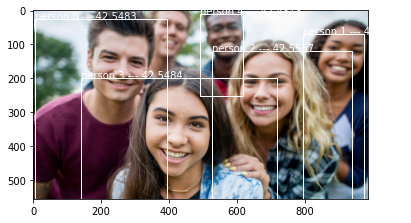

In [80]:
print("Total person detected in given image: {}".format(len(v_boxes)))

pyplot.imshow(data)
ax = pyplot.gca()
for i in range(len(v_boxes)):
    box = v_boxes[i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='white')
    ax.add_patch(rect)
    label = "{} {} --- {:.4f}".format(v_labels[i], i, v_scores[i])
    pyplot.text(x1, y1, label, color='white')
pyplot.show()